In [3]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


extracted_path = 'processed_faces'

In [6]:
# 2. Load Images and Labels
def load_images_labels(folder_path):
    images = []
    labels = []
    class_names = os.listdir(folder_path)
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                img = plt.imread(img_path)
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

images, labels = load_images_labels(extracted_path)
print(f"Loaded {len(images)} images.")

# 3. Filter images with valid labels only
valid_labels = ['happy', 'sad', 'angry', 'surprise', 'fear', 'disgust', 'neutral']
valid_idx = np.isin(labels, valid_labels)
images = images[valid_idx]
labels = labels[valid_idx]

# 4. Encode labels to integers
unique_labels = np.unique(labels)
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
encoded_labels = np.array([label_to_idx[label] for label in labels])

print(idx_to_label)

Loaded 30159 images.


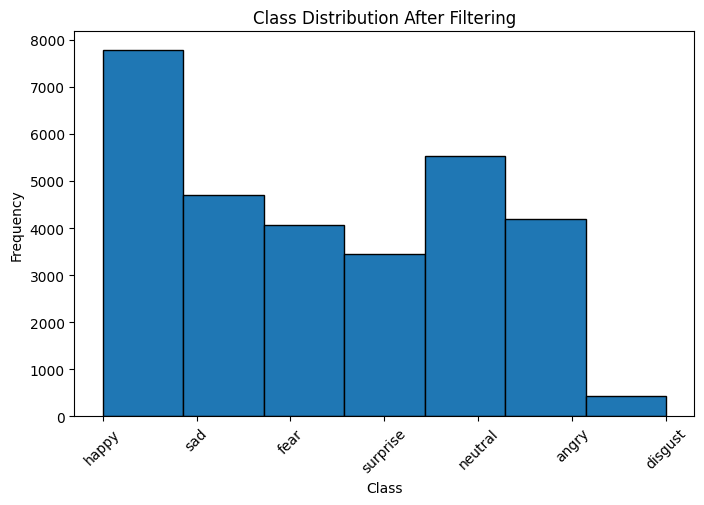

Class weights: {0: np.float64(1.0292471503651628), 1: np.float64(9.973214285714286), 2: np.float64(1.0583219286240657), 3: np.float64(0.5531427104157879), 4: np.float64(0.7775543352154072), 5: np.float64(0.9170771756978654), 6: np.float64(1.2517224205196313)}


In [7]:
# 5. Class Distribution
plt.figure(figsize=(8,5))
plt.hist(labels, bins=len(unique_labels), edgecolor='black')
plt.title('Class Distribution After Filtering')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 6. Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

# 7. Data Augmentation Strategy
augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

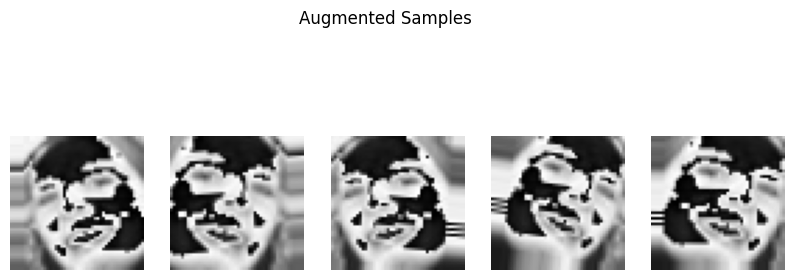

In [8]:
# Example augmentation preview
example_idx = 0
example_image = images[example_idx].reshape(48, 48, 1)
example_image = np.expand_dims(example_image, axis=0)

plt.figure(figsize=(10, 4))
for i, batch in enumerate(augmenter.flow(example_image, batch_size=1)):
    plt.subplot(1,5,i+1)
    plt.imshow(batch[0].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 4:
        break
plt.suptitle('Augmented Samples')
plt.show()

In [14]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

# === 1. Setup ===
extracted_path = 'processed_faces'
output_dir = 'augmented_dataset'
os.makedirs(output_dir, exist_ok=True)

# === 2. Load Images and Labels ===
def load_images_labels(folder_path):
    images = []
    labels = []
    class_names = os.listdir(folder_path)
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                img = plt.imread(img_path)
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

images, labels = load_images_labels(extracted_path)
print(f"Loaded {len(images)} images.")

# Filter valid labels
valid_labels = ['happy', 'sad', 'angry', 'surprise', 'fear', 'disgust', 'neutral']
valid_idx = np.isin(labels, valid_labels)
images = images[valid_idx]
labels = labels[valid_idx]

# Encode labels
unique_labels = np.unique(labels)
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
encoded_labels = np.array([label_to_idx[label] for label in labels])

print("Label mapping:", idx_to_label)

# === 3. Define Augmenter ===
augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# === 4. Apply Augmentation and Save ===
save_records = []

n_augmented_per_image = 5  # how many augmented images you want per original image

for idx, (image, label) in enumerate(zip(images, labels)):
    # Expand dims to (1, H, W, C)
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)

    # Augment multiple times per image
    aug_iter = augmenter.flow(image, batch_size=1)

    for aug_idx in range(n_augmented_per_image):
        aug_image = next(aug_iter)[0]
        aug_img = array_to_img(aug_image)

        filename = f"{idx}_{aug_idx}.png"
        file_path = os.path.join(output_dir, filename)
        aug_img.save(file_path)

        save_records.append({
            'filename': filename,
            'label': label
        })

print(f"Saved {len(save_records)} augmented images to '{output_dir}' folder.")

# === 5. Save Label Mapping to CSV ===
labels_df = pd.DataFrame(save_records)
csv_filename = 'augmented_labels.csv'
labels_df.to_csv(csv_filename, index=False)

print(f"Saved label mapping to '{csv_filename}'.")

# === 6. Zip Everything ===
zip_filename = 'augmented_dataset.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)
    zipf.write(csv_filename)  # also include the labels CSV

print(f"Everything zipped into '{zip_filename}'.")


Loaded 30159 images.
Label mapping: {0: np.str_('angry'), 1: np.str_('disgust'), 2: np.str_('fear'), 3: np.str_('happy'), 4: np.str_('neutral'), 5: np.str_('sad'), 6: np.str_('surprise')}
Saved 150795 augmented images to 'augmented_dataset' folder.
Saved label mapping to 'augmented_labels.csv'.
Everything zipped into 'augmented_dataset.zip'.


In [4]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# === PARAMETERS ===
input_csv = 'augmented_labels.csv'
input_images_dir = 'augmented_dataset'
output_base_dir = 'split_dataset'
split_ratios = (0.6, 0.2, 0.2)  # train, val, test

# === 1. Create base output directories ===
os.makedirs(output_base_dir, exist_ok=True)

# === 2. Load labels CSV ===
labels_df = pd.read_csv(input_csv)

# Get list of unique labels
unique_labels = labels_df['label'].unique()

# === 3. For each label, split and copy files ===
for label in unique_labels:
    # Filter rows for this label
    label_df = labels_df[labels_df['label'] == label]
    filenames = label_df['filename'].values

    # --- Split: train vs temp ---
    train_files, temp_files = train_test_split(
        filenames, test_size=(1 - split_ratios[0]), random_state=42, shuffle=True
    )
    # --- Split: val vs test ---
    val_ratio_adjusted = split_ratios[1] / (split_ratios[1] + split_ratios[2])
    val_files, test_files = train_test_split(
        temp_files, test_size=(1 - val_ratio_adjusted), random_state=42, shuffle=True
    )

    splits = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }

    # === 4. Copy files into split folders ===
    for split_name, split_filenames in splits.items():
        split_label_dir = os.path.join(output_base_dir, split_name, label)
        os.makedirs(split_label_dir, exist_ok=True)

        for filename in split_filenames:
            src = os.path.join(input_images_dir, filename)
            dst = os.path.join(split_label_dir, filename)
            shutil.copy(src, dst)

    print(f"{label}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print(f"\n✅ Dataset split complete! Output saved under '{output_base_dir}'")


happy: 23367 train, 7789 val, 7789 test
sad: 14094 train, 4698 val, 4698 test
fear: 12213 train, 4071 val, 4071 test
surprise: 10326 train, 3442 val, 3442 test
neutral: 16623 train, 5541 val, 5541 test
angry: 12558 train, 4186 val, 4186 test
disgust: 1296 train, 432 val, 432 test

✅ Dataset split complete! Output saved under 'split_dataset'
